# Машинное обучение, ВМК МГУ

## Практическое задание 4. Разложение ошибки на смещение и разброс. Градиентный бустинг ~~своими руками~~

### Общая информация

Дата выдачи: 30.11.2020 01:00

Мягкий дедлайн: 01:00MSK 14.12.2020

Жесткий дедлайн: 01:00MSK 21.12.2020

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-04-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston. 
Также в задании вам будет предложено пообучать готовые модели градиентного бустинга и CatBoost.

**Напоминание:**
    
* Все ваши графики должны быть **"красивыми"** --- подробнее о том, как их оформлять, можно найти в первом практическом задании. При несоответствии какиму-то из критериев вам могут снять баллы.
* Пишите в текстовых ячейках/print в коде ответы на **все вопросы из заданий/просьбы сделать выводы** --- при их отсутствии мы не можем понять, сделали ли вы задание и понимаете, что происходит, и поэтому будем снижать баллы

## Часть 1. Bias-Variance Decomposition

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sn
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split
plt.style.use("seaborn")

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
print(boston["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [5]:
X = boston["data"]
y = boston["target"]

In [6]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [7]:
z = np.random.normal(loc=5, scale=3, size=10000)
(z**2).mean()

33.78707463013997

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__Задание 1. (1.5 баллa)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [8]:
from sklearn.metrics import mean_squared_error


def bootstrap(n, size, replace=True):
    index = np.random.choice(n, size, replace=replace)
    inv_index = np.asarray(list(set(np.arange(n))-set(index)))
    return index, inv_index


def compute_biase_variance(regressor, X, y, num_runs=100, size=400):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)

    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    y_preds = np.empty((num_runs, X.shape[0]))
    indexs = np.empty((num_runs, size))

    y_average = np.zeros(X.shape[0])
    n_sum = np.zeros(X.shape[0])

    for i in range(num_runs):
        index, inv_index = bootstrap(X.shape[0], size)
        indexs[i] = index

        regressor.fit(X[index], y[index])
        y_pred = regressor.predict(X[inv_index])
        y_preds[i, inv_index] = y_pred

        y_average[inv_index] += y_pred
        n_sum[inv_index] += np.ones(inv_index.size)

    mask = (y_average != 0)
    y_average[mask] = y_average[mask]/n_sum[mask]
    bias = ((y[mask]-y_average[mask])**2).mean()
    variance = 0
    error = 0
    for i in range(num_runs):
        index = indexs[i]
        inv_index = np.asarray(list(set(np.arange(X.shape[0]))-set(index)))
        y_test = y[inv_index]
        y_pred = y_preds[i, inv_index]
        variance += ((y_pred-y_average[inv_index])**2).mean()
        error += mean_squared_error(y_pred, y_test)

    return bias, variance/num_runs, error/num_runs

**Задание 2. (0.5 баллa)**

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.


In [9]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [188]:
metrics = {}
metrics["linear"] = compute_biase_variance(Ridge(), X, y, num_runs=100)
metrics["decision_tree"] = compute_biase_variance(DecisionTreeRegressor(), X, y, num_runs=100)
metrics["random_forest"] = compute_biase_variance(RandomForestRegressor(), X, y, num_runs=100)

In [189]:
for model, tmp in metrics.items():
    bias, var, err = tmp
    print(f"{model}: bias = {bias: .2f}, variance = {var:.2f}, error = {err: .2f}, bias + var - error = {bias+var-err:.2f}")

linear: bias =  23.88, variance = 1.06, error =  24.65, bias + var - error = 0.28
decision_tree: bias =  10.42, variance = 13.57, error =  23.99, bias + var - error = -0.00
random_forest: bias =  11.50, variance = 2.81, error =  14.71, bias + var - error = -0.40


Посмотрим на работу бэггинга

Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

**Ответ:** Действительно, разложение ошибки на разброс и смещение дает довольно точные результаты для всех трех моделей.
Также очень заметно, что decision tree и random forest дают разброс намного меньше, чем линейная регрессия, но дисперсия у них выше, чем у линейной регрессии. То, что мы обсуждали на семинарах(в контексте поведения разных моделей) хорошо кореллирует с полученными результатами.

Вспомните во сколько раз в теории бутстрап уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните,  почему.  
**Ответ**: **????????????????????????????????????????????????????????????**


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__Задание 3. (1.5 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [105]:
import matplotlib.patches as mpatches


def plot_predictions(regressor, X, y, num_runs=20, num_test_objects=10, size=400, title=""):
    """
    plot graphics described above
    """
    np.random.seed(1)
    test_index, inv_test_index = bootstrap(X.shape[0], num_test_objects, replace=False)
    X_train, y_train = X[inv_test_index], y[inv_test_index]
    X_test, y_test = X[test_index], y[test_index]
    for i in range(num_runs):
        index, _ = bootstrap(X_train.shape[0], size)
        regressor.fit(X_train[index], y_train[index])
        y_pred = regressor.predict(X_test)
        sn.scatterplot(x=np.arange(num_test_objects), y=y_pred, color="tomato", alpha=0.6, s=100)
    sn.scatterplot(x=np.arange(num_test_objects), y=y_test, color="black", alpha=0.8, s=120)
    plt.xlim([-1, num_test_objects])
    plt.xticks(np.arange(num_test_objects), [f"obj{i}" for i in range(num_test_objects)], fontsize=12)
    plt.ylabel("Значения тагрета", fontsize=14)

    leg_1 = mpatches.Patch(color='tomato', alpha=0.8, label='predict')
    leg_2 = mpatches.Patch(color='black', alpha=0.8, label='true')
    plt.legend(handles=[leg_1, leg_2], fontsize=12, loc="upper right", framealpha=0.5)
    plt.title(title, fontsize=14)

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

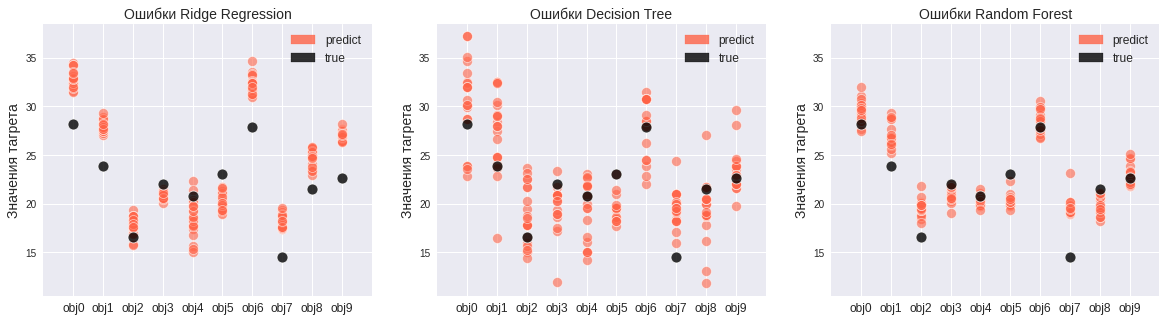

In [106]:
plt.figure(figsize=(20, 5))
ax1 = plt.subplot(131)
plot_predictions(Ridge(), X, y, title="Ошибки Ridge Regression")
ax2 = plt.subplot(132, sharey=ax1)
plot_predictions(DecisionTreeRegressor(), X, y, title="Ошибки Decision Tree")
ax3 = plt.subplot(133, sharey=ax1)
plot_predictions(RandomForestRegressor(), X, y, title="Ошибки Random Forest")

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

**Ответ:**  
В случае линейной регрессии четко видно, что модель имеет довольно большое смещение, но разборс небольшой. Это связано с тем, что модель недостаточно хорошо может описать данные - зависимость между таргетом и признаками нелинейная(и еще регуляризация мешает).  
В случае Decision Tree смещение уже не такое явное, но смещение очень сильно увеличилось. Это говорит о том, что модель переобучилась.  
Radom Forest показал хорошие результаты - смешение и разборс у этого алгоритма самые маленькие. Это связано с тем, что Random Forest - это композиция решаюших деревьев и за счет этого сильно понижается разборс(смещение относительно DT, почти не поменялось)

### Часть 2. Градиентный бустинг

**Задание 4 (1 балл)**

Мы будем использовать данные из [соревнования](https://www.kaggle.com/t/b710e05dc0bd424995ca94da5b639869) (вам нужны только данные, посылать туда ничего не надо).
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной (TARGET);
* Удалите ненужные столбцы:
    * Воспользуйтесь описанием соревнования
    * При желании, воспользуйтесь методами feature selection/стат. методами, если хотите. Объясните, что использовали и почему решили выкинуть тот или иной признак.
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0. Если считаете нужным, сделайте сбалансированное по классам разбиение.

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

In [3]:
data = pd.read_csv("application_train.csv")

In [4]:
data.shape

(215257, 122)

In [5]:
data.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,247330,0,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,425716,1,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,331625,0,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,455397,0,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
4,449114,0,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215257 entries, 0 to 215256
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 200.4+ MB


In [7]:
data.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

In [8]:
(data.isna().sum() != 0).sum()

67

In [9]:
data.isna().mean().values

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.71648773e-05, 9.24476324e-04, 4.24144163e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.58914693e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.13155902e-01, 4.64560967e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.63275526e-01, 2.19737337e-03, 1.99003981e-01,
       5.07765137e-01, 5.85272488e-01, 4.87737913e-01, 6.64967922e-01,
       6.98592845e-01, 5.32948987e-01, 5.03667709e-01, 4.97925735e-01,
       6.78240429e-01, 5.93741435e-01, 6.83271624e-01, 5.02116075e-01,
      

In [10]:
y = data["TARGET"].values
X = data.drop(columns=["TARGET", "SK_ID_CURR"])

In [11]:
X.shape

(215257, 120)

In [12]:
y.mean(), y.sum()  # первого класса очень мало

(0.08088935551457095, 17412)

In [13]:
object_cols = X.columns[X.dtypes == object]
int_cols = X.columns[X.dtypes == int]
float_cols = X.columns[X.dtypes == float]
non_object_cols = X.columns[X.dtypes != object]

In [14]:
X[non_object_cols] = X[non_object_cols].fillna(X[non_object_cols].mean())
X[object_cols] = X[object_cols].fillna("UNKNOWN(NAN)")

In [17]:
from sklearn.feature_selection import f_regression

In [18]:
corr = f_regression(X[non_object_cols].values, y, center=True)

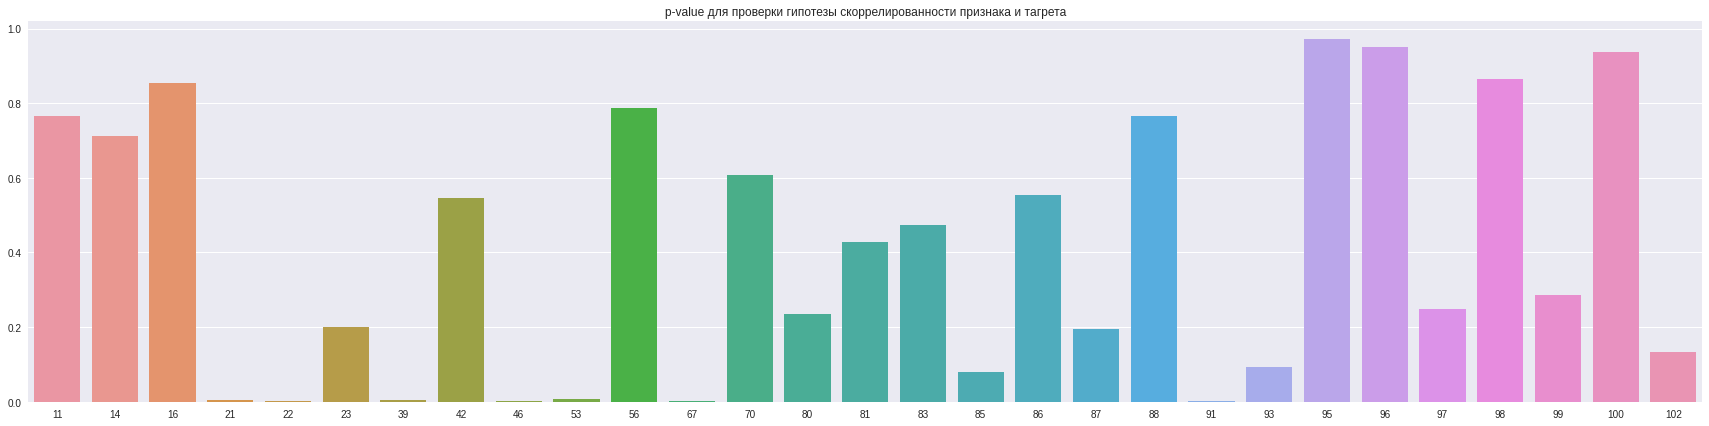

In [19]:
plt.figure(figsize=(30, 7))
threshold = 0.001
bar = sn.barplot(y=corr[1][corr[1] > threshold], x=np.arange(non_object_cols.size)[corr[1] > threshold])
plt.title("p-value для проверки гипотезы скоррелированности признака и тагрета")
plt.show()

**Пока обойдемся без выкидывания признаков**  
Сейчас подумал, что странно смотреть на корреляцию признаков и бинарного таргета...  
но это слишком красивая картинка, поэтому оставлю 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, shuffle=True, stratify=y, random_state=42)

**Задание 5 (1 балл)**

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. **Получилась ли заметная разнциа в качестве? Как вы думаете, почему?**

**Замечание:**
* В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [21]:
import lightgbm as lgb
from catboost import CatBoostClassifier

In [202]:
lgb_model = lgb.LGBMClassifier(verbose=0)
cat_model = CatBoostClassifier(verbose=0)


lgb_time = %timeit -n 1 -r 1 lgb_model.fit(X_train[non_object_cols], y_train)
cat_time = %timeit -n 1 -r 1 cat_model.fit(X_train[non_object_cols], y_train)

lgb_pred = lgb_model.predict_proba(X_test[non_object_cols])
cat_pred = cat_model.predict_proba(X_test[non_object_cols])

3.32 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
31.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [203]:
pr = precision_recall_curve(y_test, lgb_pred[:, 1])
print(f"Lgb: pr_score = {auc(pr[1],pr[0]):.4f}")
pr = precision_recall_curve(y_test, cat_pred[:, 1])
print(f"CatBoost: pr_score = {auc(pr[1],pr[0]):.4f}")

Lgb: pr_score = 0.2322
CatBoost: pr_score = 0.2334


**Ответ:** Разница между LGB и CatBoost получилась несущественной. Скорее всего это связано с тем, что мы не используем все признаки и не подбирали гиперпараметры на кросс-валидации

__Задание 6. (2 балла)__

Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Масштаб значений предлагается посмотреть [тут](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/seminars/sem10-gbm.ipynb).

**Проанализируйте соотношения получившихся оптимальных глубины и количества деревьев в зависимости от алгоритма.** 

**Если на перебор гиперпараметров уходит много времени, то переберите значениях каких-нибудь 1-2 гиперпараметров, а не всех предложенных 4**

In [28]:
from sklearn.metrics import make_scorer


def pr_score(y_true, y_pred):
    pr = precision_recall_curve(y_true, y_pred)
    return auc(pr[1], pr[0])


sk_pr_score = make_scorer(pr_score, greater_is_better=True, needs_proba=True)

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [30]:
metrics = {"pr_auc": sk_pr_score, "roc_auc": "roc_auc"}

learning_rate = [0.01, 0.1, 0.2, 1]
max_depth = [-1, 3, 5, 7]
num_estimators = [30, 50, 100, 300, 800]
# лосс функцию решил не подбирать и оставить по умолчанию

## LightGBM

In [208]:
params = {
    "learning_rate": learning_rate,
    "max_depth": max_depth,
    "n_estimators": num_estimators
}

gs = GridSearchCV(lgb.LGBMClassifier(random_state=42), params, scoring=metrics, cv=3, refit=False)
gs.fit(X_train[non_object_cols], y_train)

GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 1],
                         'max_depth': [-1, 3, 5, 7],
                         'n_estimators': [10, 50, 100, 300, 800]},
             refit=False,
             scoring={'pr_auc': make_scorer(pr_score, needs_proba=True),
                      'roc_auc': 'roc_auc'})

In [209]:
params = gs.cv_results_["params"]
pr_auc_score_lgb = gs.cv_results_["mean_test_pr_auc"]
best_params = params[pr_auc_score_lgb.argmax()]

In [211]:
print("pr_auc:", pr_auc_score_lgb.max())
print("best_params", best_params)

pr_auc: 0.23116781845292245
best_params {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


### На тестовой выборке

In [289]:
lgb_model = lgb.LGBMClassifier(**best_params, random_state=42)
lgb_time = %timeit - n 1 - r 1 lgb_model.fit(X_train[non_object_cols], y_train)
y_pred = lgb_model.predict_proba(X_test[non_object_cols])

4.85 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [290]:
"PR_AUC:", pr_score(y_test, y_pred[:, 1]), "ROC_AUC:", roc_auc_score(y_test, y_pred[:, 1])

('PR_AUC:', 0.23587191141175973, 'ROC_AUC:', 0.7505198646932741)

## CatBoost

In [231]:
metrics = {"pr_auc": sk_pr_score, "roc_auc": "roc_auc"}

learning_rate = [0.01, 0.1, 1]
max_depth = [3, 6, 7]
num_estimators = [30, 50, 100, 300, 800]

In [232]:
params = {
    "learning_rate": learning_rate,
    "depth": max_depth,
    "iterations": num_estimators
}

gs = GridSearchCV(CatBoostClassifier(random_state=42, verbose=False),
                  params, scoring=metrics, cv=3, refit=False)
gs.fit(X_train[non_object_cols], y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f0449df00a0>,
             param_grid={'depth': [3, 6, 7], 'iterations': [50, 100, 300, 800],
                         'learning_rate': [0.01, 0.1, 1]},
             refit=False,
             scoring={'pr_auc': make_scorer(pr_score, needs_proba=True),
                      'roc_auc': 'roc_auc'})

In [233]:
params = gs.cv_results_["params"]
pr_auc_score_lgb = gs.cv_results_["mean_test_pr_auc"]
best_params = params[pr_auc_score_lgb.argmax()]

In [234]:
print("pr_auc:", pr_auc_score_lgb.max())
print("best_params", best_params)

pr_auc: 0.2321868149945545
best_params {'depth': 3, 'iterations': 300, 'learning_rate': 0.1}


In [286]:
сat_model = CatBoostClassifier(**best_params, random_state=42)
cat_time = %timeit - n 1 - r 1 cat_model.fit(X_train[non_object_cols], y_train)
y_pred = cat_model.predict_proba(X_test[non_object_cols])

37.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [288]:
"PR_AUC:", pr_score(y_test, y_pred[:, 1]), "ROC_AUC:", roc_auc_score(y_test, y_pred[:, 1])

('PR_AUC:', 0.23343237811742812, 'ROC_AUC:', 0.7508048272516121)

**Ответ:**

**Задание 7 (1.5 баллa)**

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

Можно использовать библиотечные реализации; при подсчете счетчиков нельзя использовать циклы.

Как меняется время, необходимое для обучения моделей в зависимости от способа кодирования? (Параметры можно не подбирать).

## Счетчики

In [35]:
from category_encoders import TargetEncoder, OneHotEncoder

In [36]:
tar_encoder = TargetEncoder(cols=object_cols)
X_train_tar = tar_encoder.fit_transform(X_train, y_train)
X_test_tar = tar_encoder.transform(X_test)

/home/tyskiy/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### LightGBM

In [38]:
lgb_model = lgb.LGBMClassifier(learning_rate=0.1, max_depth=4, n_estimators=300, random_state=42)
lgb_time = %timeit - n 1 - r 1 lgb_model.fit(X_train_tar, y_train)
y_pred = lgb_model.predict_proba(X_test_tar)

6.73 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [39]:
"PR_AUC:", pr_score(y_test, y_pred[:, 1]), "ROC_AUC:", roc_auc_score(y_test, y_pred[:, 1])

('PR_AUC:', 0.24164615486160107, 'ROC_AUC:', 0.7560477584050553)

### CatBoost

In [42]:
сat_model = CatBoostClassifier(depth=4, iterations=400, learning_rate=0.1, random_state=42, verbose=False)
cat_time = %timeit - n 1 - r 1 сat_model.fit(X_train_tar, y_train)
y_pred = сat_model.predict_proba(X_test_tar)

12.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [43]:
"PR_AUC:", pr_score(y_test, y_pred[:, 1]), "ROC_AUC:", roc_auc_score(y_test, y_pred[:, 1])

('PR_AUC:', 0.2461774832057446, 'ROC_AUC:', 0.7585524340653719)

## Oh.. ONE HOT

In [44]:
hot_encoder = OneHotEncoder(cols=object_cols)
X_train_hot = hot_encoder.fit_transform(X_train, y_train, cols=object_cols)
X_test_hot = hot_encoder.transform(X_test)

/home/tyskiy/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [45]:
X_train_hot.shape

(150679, 250)

### LightGBM

In [48]:
lgb_model = lgb.LGBMClassifier(learning_rate=0.1, max_depth=3,
                               n_estimators=300, random_state=42)
lgb_time = %timeit -n 1 -r 1 lgb_model.fit(X_train_hot, y_train)
y_pred = lgb_model.predict_proba(X_test_hot)

8.61 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [49]:
"PR_AUC:", pr_score(y_test, y_pred[:, 1]), "ROC_AUC:", roc_auc_score(y_test, y_pred[:, 1])

('PR_AUC:', 0.24100907706327798, 'ROC_AUC:', 0.7569332654370968)

### CatBoost

In [51]:
сat_model = CatBoostClassifier(depth=3, iterations=300, learning_rate=0.1, random_state=42, verbose=False)
cat_time = %timeit -n 1 -r 1 сat_model.fit(X_train_hot, y_train)
y_pred = сat_model.predict_proba(X_test_hot)

8.06 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [52]:
"PR_AUC:", pr_score(y_test, y_pred[:, 1]), "ROC_AUC:", roc_auc_score(y_test, y_pred[:, 1])

('PR_AUC:', 0.24255900034426436, 'ROC_AUC:', 0.7560013810768427)

**Задание 8 (1 балл)**

Для CatBoost можно не делать ручную обработку категориальных признаков, а подавать как есть. Обучите модель CatBoost, не обрабатывая специально категориальные признаки, замерьте время обучения (параметры возьмите из предыдущего пункта).  Сравните с временем обучения модели CatBoost из предыдущего пункта. Как изменилось время? Почему?

In [54]:
сat_model = CatBoostClassifier(depth=4, iterations=400, learning_rate=0.1,
                               cat_features=object_cols,
                               random_state=42, verbose=False)

cat_time = %timeit -n 1 -r 1 сat_model.fit(X_train, y_train, cat_features=object_cols)
y_pred = сat_model.predict_proba(X_test)

48.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [55]:
"PR_AUC:", pr_score(y_test, y_pred[:, 1]), "ROC_AUC:", roc_auc_score(y_test, y_pred[:, 1])

('PR_AUC:', 0.24402446793524174, 'ROC_AUC:', 0.7576827849834572)

**Бонус. (1 балл)**

Подберите оптимальные параметры для LightGBM с вещественными и категориальными признаками (предварительно обработанные каким-нибудь способом). Подберите оптимальные параметры для CatBoost с вещественными и необработанными категориальными признаками. Сравните качество моделей на наилучших параметрах. Какой метод получился лучше с точки зрения качества? Совпадает ли результат с вашими ожиданиями?

In [30]:
metrics = {"pr_auc": sk_pr_score, "roc_auc": "roc_auc"}

learning_rate = [0.01, 0.1, 0.2, 1]
max_depth = [-1, 3, 5, 7]
num_estimators = [30, 50, 100, 300, 800]
# лосс функцию решил не подбирать и оставить по умолчанию

## LightGBM

In [208]:
params = {
    "learning_rate": learning_rate,
    "max_depth": max_depth,
    "n_estimators": num_estimators
}

gs = GridSearchCV(lgb.LGBMClassifier(random_state=42), params, scoring=metrics, cv=3, refit=False)
gs.fit(X_train_tar, y_train)

GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 1],
                         'max_depth': [-1, 3, 5, 7],
                         'n_estimators': [10, 50, 100, 300, 800]},
             refit=False,
             scoring={'pr_auc': make_scorer(pr_score, needs_proba=True),
                      'roc_auc': 'roc_auc'})

In [209]:
params = gs.cv_results_["params"]
pr_auc_score_lgb = gs.cv_results_["mean_test_pr_auc"]
best_params = params[pr_auc_score_lgb.argmax()]

In [211]:
print("pr_auc:", pr_auc_score_lgb.max())
print("best_params", best_params)

pr_auc: 0.23116781845292245
best_params {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


### На тестовой выборке

In [289]:
lgb_model = lgb.LGBMClassifier(**best_params, random_state=42)
lgb_time = %timeit - n 1 - r 1 lgb_model.fit(X_train_tar, y_train)
y_pred = lgb_model.predict_proba(X_test_tar)

4.85 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [290]:
"PR_AUC:", pr_score(y_test, y_pred[:, 1]), "ROC_AUC:", roc_auc_score(y_test, y_pred[:, 1])

('PR_AUC:', 0.23587191141175973, 'ROC_AUC:', 0.7505198646932741)

## CatBoost

In [231]:
metrics = {"pr_auc": sk_pr_score, "roc_auc": "roc_auc"}

learning_rate = [0.01, 0.1, 1]
max_depth = [3, 4, 7]
num_estimators = [30, 50, 100, 300, 800]

In [232]:
params = {
    "learning_rate": learning_rate,
    "depth": max_depth,
    "iterations": num_estimators
}

gs = GridSearchCV(CatBoostClassifier(random_state=42, cat_features=object_cols, verbose=False),
                  params, scoring=metrics, cv=3, refit=False)
gs.fit(X_train[non_object_cols], y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f0449df00a0>,
             param_grid={'depth': [3, 6, 7], 'iterations': [50, 100, 300, 800],
                         'learning_rate': [0.01, 0.1, 1]},
             refit=False,
             scoring={'pr_auc': make_scorer(pr_score, needs_proba=True),
                      'roc_auc': 'roc_auc'})

In [233]:
params = gs.cv_results_["params"]
pr_auc_score_lgb = gs.cv_results_["mean_test_pr_auc"]
best_params = params[pr_auc_score_lgb.argmax()]

In [234]:
print("pr_auc:", pr_auc_score_lgb.max())
print("best_params", best_params)

pr_auc: 0.2321868149945545
best_params {'depth': 3, 'iterations': 300, 'learning_rate': 0.1}


In [286]:
сat_model = CatBoostClassifier(**best_params, cat_features=object_cols, random_state=42)
cat_time = %timeit - n 1 - r 1 cat_model.fit(X_train[non_object_cols], y_train)
y_pred = cat_model.predict_proba(X_test[non_object_cols])

37.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [288]:
"PR_AUC:", pr_score(y_test, y_pred[:, 1]), "ROC_AUC:", roc_auc_score(y_test, y_pred[:, 1])

('PR_AUC:', 0.23343237811742812, 'ROC_AUC:', 0.7508048272516121)

**Бонус (0.2 балла)**

Вставьте лучший мем 2020

#### Your meme here ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
![](https://sun9-64.userapi.com/c841230/v841230917/34efa/Wd22hcNCTJc.jpg)